# Clustering of the VAE latent space for anomaly detection of diverse time-series sensor data
Trained on non-fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve, auc

In [3]:
from IPython.core.debugger import set_trace

In [36]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / 'src'))

from clustering import *
device

device(type='cuda', index=0)

In [5]:
desc

'accumulator'

In [6]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [7]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 14.268
Epoch: 210


Next we need to load the datasets of sensors readings.

In [8]:
data_path = Path(f'../data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [9]:
print(len(train_dl), len(val_dl), len(test_dl))

27 7 1157


Run model on training set combined with validation set to get latent vectors to use for building clustering model.

In [10]:
train_latents, targets = compute_latents(train_dl, model)
assert np.all(targets == 0), 'Invalid training data - faults present'
print(train_latents.shape)

100%|██████████| 27/27 [00:04<00:00,  6.06it/s]

(839, 50)


In [11]:
val_latents, targets = compute_latents(val_dl, model)
assert np.all(targets == 0), 'Invalid training data - faults present'
print(val_latents.shape)

100%|██████████| 7/7 [00:01<00:00,  5.64it/s]

(209, 50)


In [12]:
latents = np.vstack([train_latents, val_latents])
print(latents.shape)

(1048, 50)


To evaluate the hyperparameter I want to minimize the information criterion as a measure of model efficiency. I prefer the bayesian version over akaike for this because it penalizes complex models more. My intuition is that a simpler clustering will perform better for general cases.

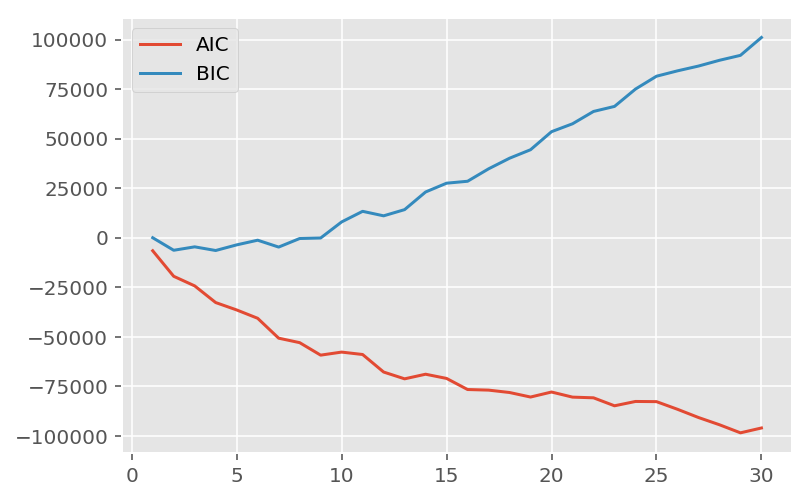

In [13]:
# Select model based on lowest BIC score
aic = []
bic = []
n_range = range(1, 31)
for n in n_range:
    gmm = GaussianMixture(n_components=n,
                          covariance_type='full',
                          random_state=0)
    gmm = gmm.fit(latents)
    aic.append(gmm.aic(latents)) 
    bic.append(gmm.bic(latents))
plt.plot(n_range, aic, label="AIC")
plt.plot(n_range, bic, label='BIC')
plt.legend()

In [14]:
# Select hyperparameter that minimizes BIC
n = n_range[np.argmin(bic)]
n

4

In [15]:
# Fit model and make predicts
gmm = GaussianMixture(n_components=n,
                      covariance_type='full',
                      random_state=0)
gmm = gmm.fit(latents)
cluster = gmm.predict(latents)
prob = gmm.predict_proba(latents)
print(f'Minimum probability = {prob.max(axis=1).min()}')

Minimum probability = 0.999975569901866


PCA can be used to visualize the clustering of the training data.

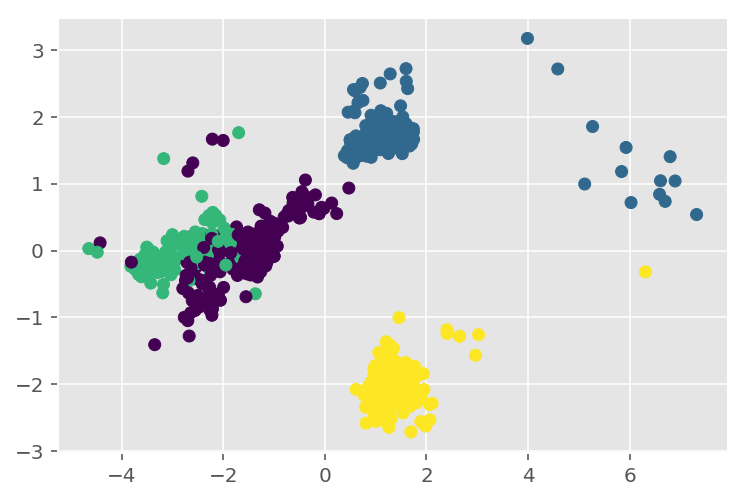

In [16]:
# Project to 2D for plotting
pca = PCA(n_components=2)
train_pca = pca.fit_transform(latents)

plt.scatter(train_pca[:, 0], train_pca[:, 1], c=cluster, cmap='viridis')

Let's calculate probabilities on the test dataset to look for an outlier threshold.

In [17]:
# Use the test set with the anomaly labels as targets
test_latents, targets = compute_latents(test_dl, model)
print(test_latents.shape)
print(test_dl.dataset.classes)

100%|██████████| 1157/1157 [00:07<00:00, 150.73it/s]

(1157, 50)
['fail', 'norm']


In [18]:
# Manually calculate the probability of each point belonging to a cluster
means = gmm.means_
covars = gmm.covariances_
print(means.shape, covars.shape)

probs = np.zeros(test_latents.shape[0])
for k in range(means.shape[0]):
    probs += multivariate_normal.pdf(test_latents,
                                     mean=means[k, :],
                                     cov=covars[k, :, :])

(4, 50) (4, 50, 50)


In [19]:
# Set all zero probabilities to min non-zero probability
non_zero = ~(probs == 0)
min_prob = probs[non_zero].min()
log_probs = probs.copy()
log_probs[~non_zero] = min_prob

# Calculate the log of probabilities for easier analysis
log_probs = np.log(log_probs)

In [20]:
# Average fault log prob
log_probs[targets == 0].mean()

-156.00365710476157

In [21]:
# Average normal log prob
log_probs[targets == 1].mean()

-0.4279922453676018

We're on the right track here. The anomalies have a lower log probability on average and the seperation looks to be much better than with MSE. Lets compare the histograms and dive into the accuracy metrics on the test dataset.

In [22]:
print('Normal')
print('95% = ', np.percentile(log_probs[targets == 1], 95))
print('75% = ', np.percentile(log_probs[targets == 1], 75))
print('50% = ', np.percentile(log_probs[targets == 1], 50))
print('25% = ', np.percentile(log_probs[targets == 1], 25))
print('5% = ', np.percentile(log_probs[targets == 1], 5))

Normal
95% =  34.45516990922621
75% =  28.09097939809661
50% =  22.739846559796984
25% =  12.153598564217269
5% =  -77.13351656301906


In [23]:
print('Anomaly')
print('95% = ', np.percentile(log_probs[targets == 0], 95))
print('75% = ', np.percentile(log_probs[targets == 0], 75))
print('50% = ', np.percentile(log_probs[targets == 0], 50))
print('25% = ', np.percentile(log_probs[targets == 0], 25))
print('5% = ', np.percentile(log_probs[targets == 0], 5))

Anomaly
95% =  27.733371263086134
75% =  13.17449313937826
50% =  -22.697079226885805
25% =  -308.34951219636025
5% =  -556.7949640943663


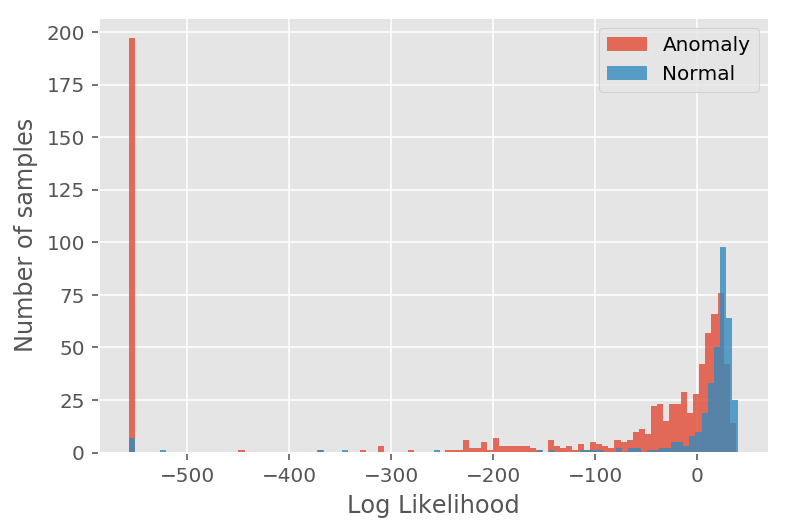

In [24]:
plt.hist(log_probs[targets == 0], bins=100, label='Anomaly', alpha=0.8)
plt.hist(log_probs[targets == 1], bins=100, label='Normal', alpha=0.8)
plt.xlabel('Log Likelihood')
plt.ylabel('Number of samples')
plt.legend()

In [25]:
min_threshold = np.percentile(log_probs[targets == 1], 5)
max_threshold = np.percentile(log_probs[targets == 1], 95)
thresholds = np.linspace(min_threshold, max_threshold, 1000)
f1_scores = np.zeros(thresholds.size)
auc_scores = np.zeros(thresholds.size)
acc_scores = np.zeros(thresholds.size)
for i, threshold in enumerate(thresholds):
    anomalies = log_probs < threshold
    # Must invert targets because fault=0
    f1_scores[i] = f1_score(1 - targets, anomalies)
    auc_scores[i] = roc_auc_score(1 - targets, anomalies)
    acc_scores[i] = accuracy_score(1 - targets, anomalies)

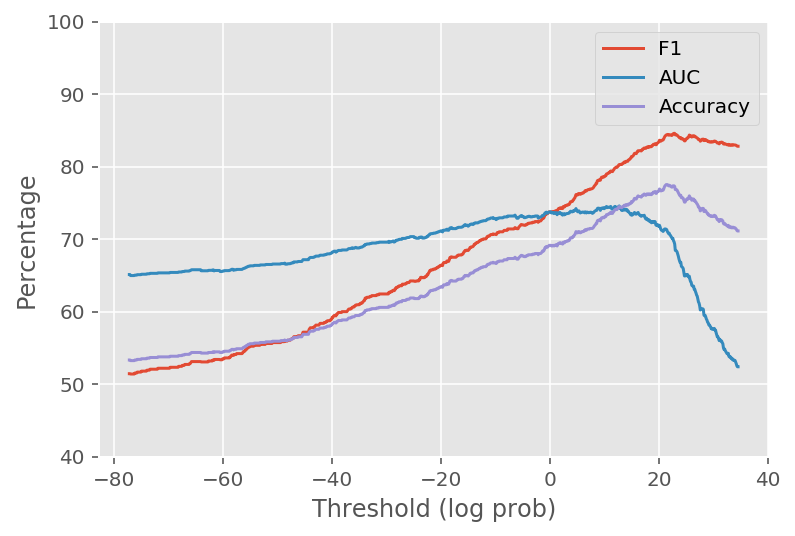

In [26]:
plt.plot(thresholds, 100 * f1_scores, label='F1')
plt.plot(thresholds, 100 * auc_scores, label='AUC')
plt.plot(thresholds, 100 * acc_scores, label='Accuracy')
plt.ylim([40, 100])
plt.ylabel('Percentage')
plt.xlabel('Threshold (log prob)')
plt.legend()

In [27]:
best_thresholds = [thresholds[np.argmax(acc_scores)],
                   thresholds[np.argmax(f1_scores)],
                   thresholds[np.argmax(auc_scores)]]
print(best_thresholds)
print('Average:', np.mean(best_thresholds))

[21.274524259851887, 22.726629289020238, 12.673594471700838]
Average: 18.891582673524322


It is necessary to select a threshold without access to labelled target data. The AUC threshold appears to be a good choice because it does better to limit false positives. It corresponds to a 25th percentile limit on the normal log probabilities. Ultimately the end user would have some control over the threshold if nuisance faults were a problem.

In [28]:
# Max scores
print(acc_scores.max(), f1_scores.max(), auc_scores.max())

0.7752808988764045 0.8460634547591068 0.7458314420267242


Text(0.5,0,'False Positive Rate')

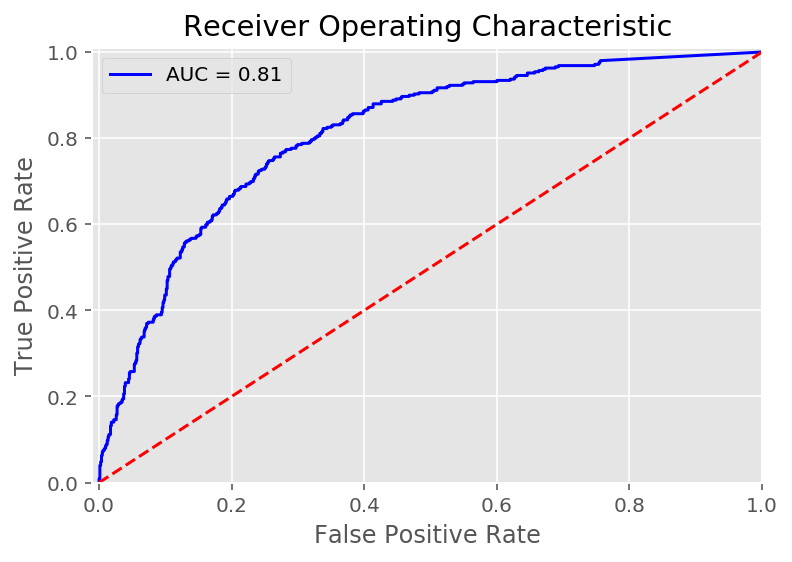

In [29]:
# Plot the ROC curve for visualization of model performance
fpr, tpr, roc_thresholds = roc_curve(targets, log_probs)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label=f'AUC = {auc(fpr, tpr):0.2f}')
plt.legend()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

As a final confirmation of the approach I want to check the metrics on the training dataset alone. Ideally all would classify as normal.

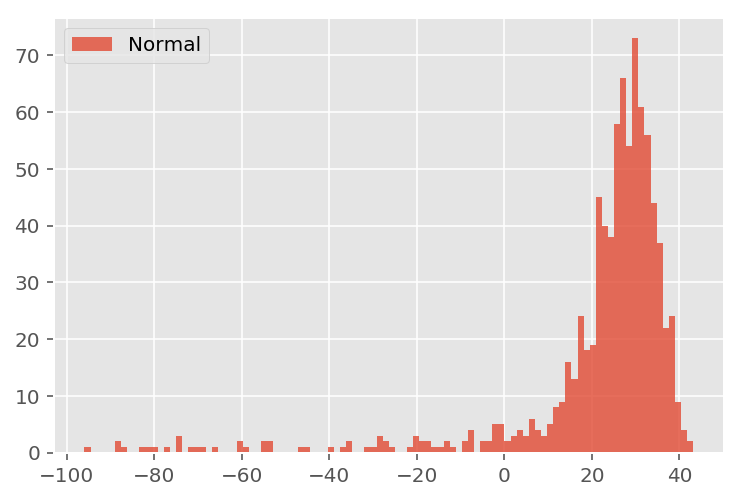

In [30]:
# Calculate log probabilities on training set
train_probs = np.zeros(train_latents.shape[0])
for k in range(means.shape[0]):
    train_probs += multivariate_normal.pdf(train_latents,
                                           mean=means[k, :],
                                           cov=covars[k, :, :])
train_probs[train_probs == 0] = train_probs[train_probs != 0].min()
train_log_probs = np.log(train_probs)

# Plot histogram to find reasonable thresholds
plt.hist(train_log_probs, bins=100, label='Normal', alpha=0.8)
plt.legend()

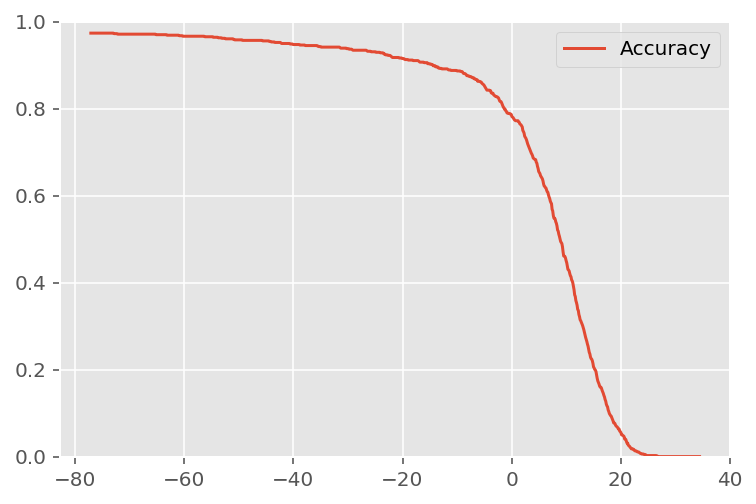

In [33]:
# Sweep thresholds and calculate metrics
train_targets = np.zeros(train_latents.shape[0])
train_acc_scores = np.zeros(thresholds.size)
for i, threshold in enumerate(np.linspace(-50, 50, 1000)):
    anomalies = train_log_probs < threshold
    train_acc_scores[i] = accuracy_score(train_targets, anomalies)

# Plot performance
plt.plot(thresholds, train_acc_scores, label='Accuracy')
plt.ylim([0, 1])
plt.legend()

In [34]:
# For comparison the training percentiles
print('Normal')
for p in range(5, 96, 5):
    print(f'{p}% = ', np.percentile(log_probs[targets == 1], p))

Normal
5% =  -77.13351656301906
10% =  -18.134589483842287
15% =  0.7885652206840694
20% =  6.471460896508674
25% =  12.153598564217269
30% =  14.631167326411468
35% =  17.44164060360125
40% =  19.774567955098345
45% =  21.417893239106235
50% =  22.739846559796984
55% =  23.543211755908956
60% =  24.54016571980789
65% =  25.823320249486915
70% =  26.979582509824283
75% =  28.09097939809661
80% =  29.15502954441591
85% =  30.93034522367095
90% =  32.31595137983663
95% =  34.45516990922621


A decent strategy for initializing the threshold is to set it at the 25% percentile.

In [41]:
threshold = np.percentile(log_probs[targets == 1], 25)
threshold

12.153598564217269

Save the means and covariances of the clusters and the threshold.

In [42]:
np.save(Path(f'../models/{date}-{desc}/cluster_means.npy'), means)
np.save(Path(f'../models/{date}-{desc}/cluster_covars.npy'), covars)
np.save(Path(f'../models/{date}-{desc}/threshold.npy'), threshold)